In [ ]:
!pip install pmdarima

In [96]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATA UNDERSTANDING**

In [247]:
#READING THE DATASET
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TSF/TimeSeries_Sales_Data_MiniProject.xls",parse_dates=True,index_col='Order Date',usecols=('Category','Sales','Order Date'))
df.head()

,Category,Sales
Order Date,,
2016-11-08,Furniture,261.9600
2016-11-08,Furniture,731.9400
2016-06-12,Office Supplies,14.6200
2015-10-11,Furniture,957.5775
2015-10-11,Office Supplies,22.3680


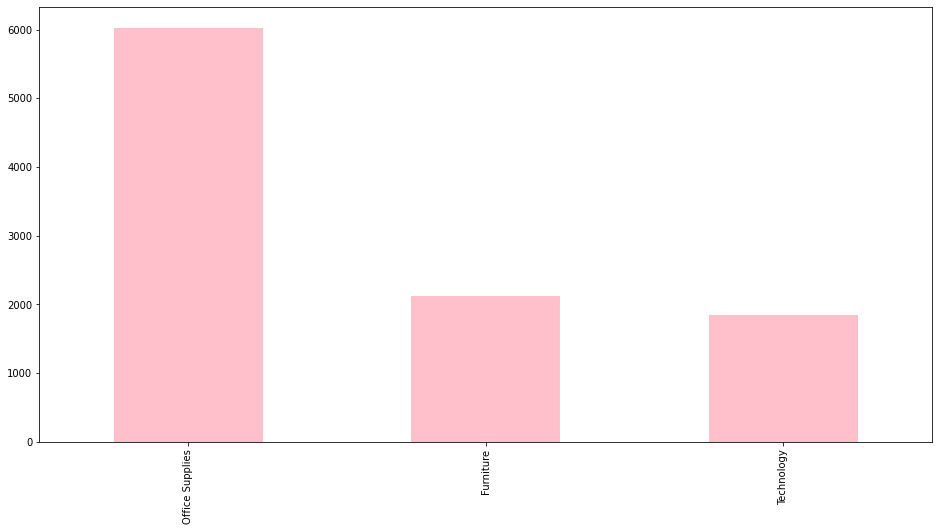

In [248]:
df['Category'].value_counts().plot(kind='bar',color='pink')

In [249]:
df.isnull().sum()

Category    0
Sales       0
dtype: int64

# **DATA CATEGORISING FOR ANALYSIS**

In [250]:
#category wise data frames
one = df.loc[df['Category'] == 'Office Supplies']
two = df.loc[df['Category'] == 'Furniture']
three = df.loc[df['Category'] == 'Technology']

In [251]:
#selecting only columns required for analysis
offsup = one['Sales']
furn = two['Sales']
tech = three['Sales']

## FUNCTIONS TO USE IN FURTHER MODEL BUILDING AND FORECASTING

In [252]:
from statsmodels.tsa.stattools import adfuller

def checkstationarity(data):
  pvalue = adfuller (data)[1]
  if pvalue < 0.05:
    msg =  "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
  else:
    msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
  return msg

In [253]:
from statsmodels.tsa.seasonal import seasonal_decompose

def checkcharacterstics(data):
  dc = seasonal_decompose(data,period=12)
  plt.rcParams.update({'figure.figsize': (16,8)})
  dc.plot().suptitle('Data Decomposition', fontsize=16)

In [254]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

def plotlag(data):
  fig,ax = plt.subplots(1,2,figsize=(20,4))
  plot_acf(data,lags=20,ax=ax[0])
  plot_pacf(data,lags=20,ax=ax[1])
  plt.show()

In [255]:
import statsmodels.api as sm

def ljungoxtest(model):
  pval = sm.stats.acorr_ljungbox(model.resid,lags=[1],return_df=True)['lb_pvalue'].values
  if pval < 0.05:
    print('Reject H0, bad model')
  else:
    print('Accept H0, good model')

In [256]:
def plotpred(data,pred):
  data.plot(label='Actual Dataset')
  pred.plot(label='Predicted Test Set')
  plt.legend()
  plt.show()

In [306]:
def forecasting(model,data):
  global fdata
  forecast = model.predict(start=len(data),end=len(data)+23,dynamic=True)
  fdata = data.append(forecast)
  fdata.plot(label="Current Sales")
  forecast.plot(label="Future Sales")
  plt.legend()
  plt.title("Forecasted Sales for the Upcoming Years")
  plt.show()

# TIME SERIES FORECASTING FOR OFFICE SUPPLIES CATEGORY

In [307]:
#CONVERTING INDEX TO DATE TIME FORMAT 
offsup.index = pd.to_datetime(offsup.index)

In [308]:
#SORTING THE INDEX
offsup.sort_index(ascending=True,inplace=True)

In [309]:
#SAMPLING THE DATA MONTHLY FOR DATA REDUCTION
osdata = offsup.resample('MS').sum()
osdata.head()

Order Date
2014-01-01     4851.080
2014-02-01     1071.724
2014-03-01     8605.879
2014-04-01    11155.074
2014-05-01     7135.624
Freq: MS, Name: Sales, dtype: float64

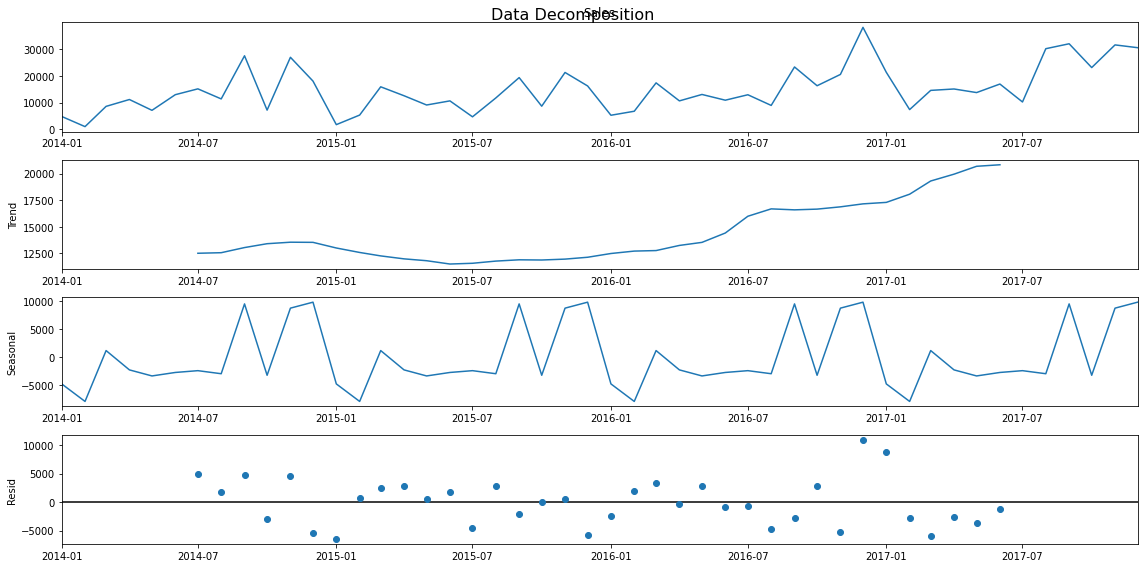

In [310]:
#PLOTS TO CHECK TREND,SEASONALITY,RESIDS
checkcharacterstics(osdata)

*DATA HAS ALL THREE TIME SERIES CHARACTERSTICS TREND, SEASONALITY AND NOISE*

In [311]:
#CHECKING FOR DATA STATIONARITY
checkstationarity(osdata)

'pvalue=0.32948727549472817. Data is not Stationary. Make the data stationary before model building'

In [312]:
osdata_diff = osdata - osdata.shift(1)
osdata_diff.dropna(inplace=True)
checkstationarity(osdata_diff)

'pvalue=0.00042872624590977896. Data is Stationary. Proceed to model building'

1. *SINCE DATA IS NON STATIONARY WE CAN MOVE WITH EITHER ARIMA OR SARIMA.*
2. *SINCE THERE IS SEASONALITY PRESENT I WILL CHOOSE SARIMA MODEL.*

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


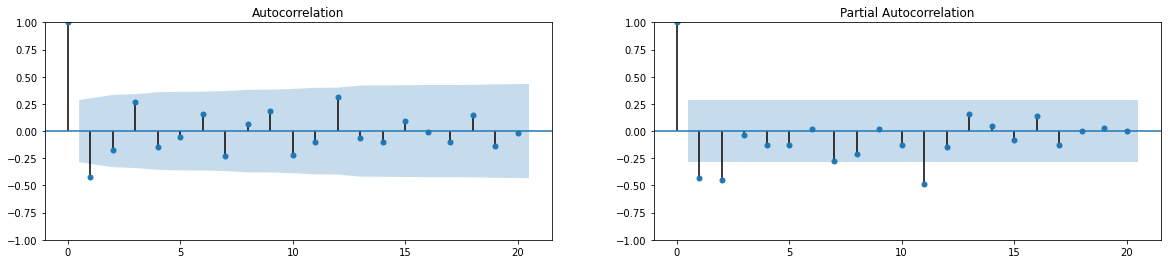

In [313]:
#CHECKING LAG VALUES
plotlag(osdata_diff)

In [265]:
#FINDING BEST P,Q,D,p,q,d values for building the model
from pmdarima import auto_arima
m1 = auto_arima(y=osdata,start_p=1,start_q=1,max_p=3,max_q=3,m=12,d=1,D=1,start_P=0,start_Q=0,seasonal=True,error_action='ignore',suppress_warnings=True,trace=True)
print(m1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=730.407, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=740.437, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=726.023, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=717.172, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=728.668, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=718.898, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=718.892, Time=0.87 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=718.780, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=725.260, Time=0.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=730.324, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=722.788, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=718.277, Time=0.62 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=722.473, Time=0.37 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=723.414, Time=0.98 sec
 ARIMA(0,1,1)(0,1,1)[12] intercep

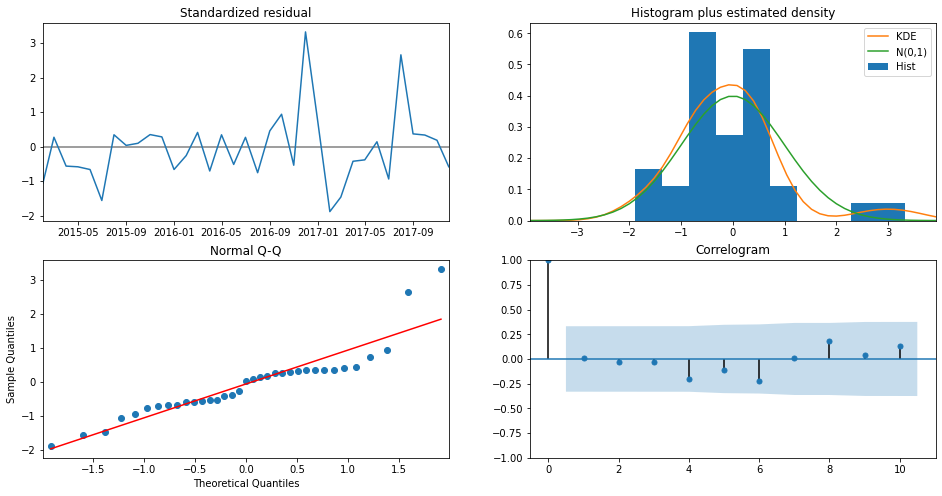

In [314]:
#CHECKING FOR MODEL DIAGNOSTICS BEFORE BULIDING
m1.plot_diagnostics()
plt.show()

1. Standardised Residuals : Thereare obvious patterns in the residuals with no uniform mean and variance.
2. KDE Curve : Dosent show normal distributions, data is skewed.
3. Normal Q-Q : Most of the data points are not on the straight line/normal reference line.

In [315]:
split1 = int(0.8 * len(osdata))
train1 = osdata[:split1]
test1 = osdata[split1:]

In [316]:
#BUILDING THE SARIMA MODEL FOR OFFICE SUPPLIES
os_model = sm.tsa.statespace.SARIMAX(train1,order=(1,1,1),seasonal_order=(0,1,1,12)).fit()
print(os_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   38
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -253.947
Date:                            Tue, 31 Jan 2023   AIC                            515.894
Time:                                    14:57:14   BIC                            520.770
Sample:                                01-01-2014   HQIC                           517.247
                                     - 02-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0075      0.415      0.018      0.986      -0.805       0.820
ma.L1         -0.6175      0.320   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [317]:
#LJUNG BOX TEST
ljungoxtest(os_model)

Accept H0, good model


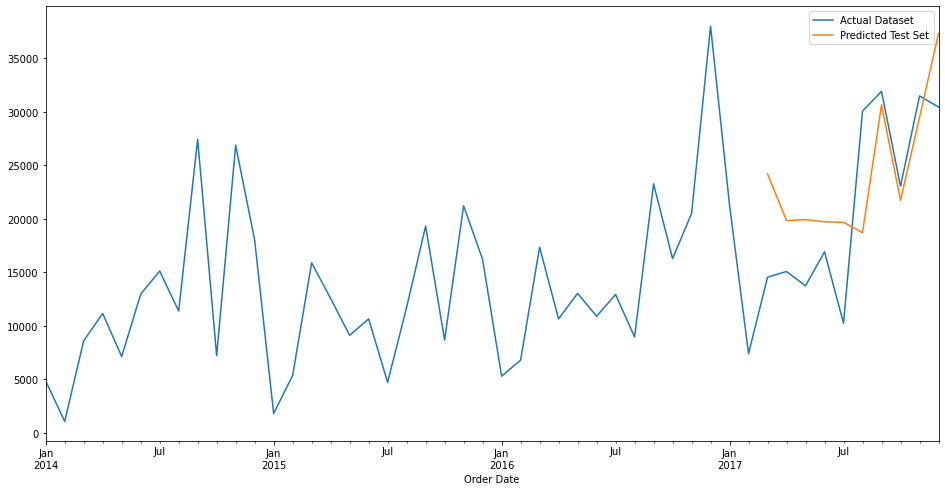

In [318]:
#PERFORMACE METRICS and PREDICTED DATA
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
pred1 = os_model.predict(start=len(train1),end=len(osdata)-1,dynamic=True)
mse1 = mean_squared_error(test1,pred1)
mape1 = mean_absolute_percentage_error(test1,pred1)
plotpred(osdata,pred1)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


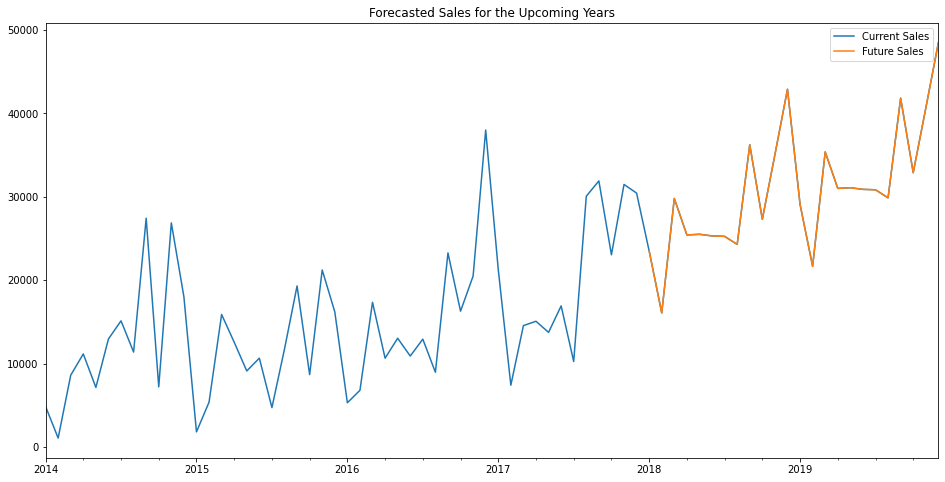

In [319]:
#FORECASTING
forecasting(os_model,osdata)

INTERPRETATIONS:

1. SARIMA MODEL WAS USED HERE FOR FORECASTING DUE TO THE PRESENCE OF SEASONALITY.
2. DATA WAS NOT STATIONARY IN THIS CATEGORY.
3. PATTERNS ARE QUIET SIMILAR TO THE PREVIOUS YEAR SALES RECORD.
4. UPWARD TREND CAN BE SEEN IN THE OVERALL DATA AND THE DATA FORECASTED.
5. YEAR END SALES IN OFFICE SUPPLY CATEGORY ARE COMPARITIVELY MORE.

# TIME SERIES FORECASTING FOR FURNITURE CATEGORY

In [331]:
#CONVERTING INDEX TO DATE TIME FORMAT 
furn.index = pd.to_datetime(furn.index)

In [332]:
#SORTING THE INDEX
furn.sort_index(ascending=True,inplace=True)

In [333]:
#SAMPLING THE DATA MONTHLY FOR DATA REDUCTION
furndata = furn.resample('MS').sum()
furndata.head()

Order Date
2014-01-01     6242.525
2014-02-01     1839.658
2014-03-01    14573.956
2014-04-01     7944.837
2014-05-01     6912.787
Freq: MS, Name: Sales, dtype: float64

In [334]:
#SMOOTHING
from statsmodels.tsa.api import ExponentialSmoothing
df2_smo = ExponentialSmoothing(furndata,trend='add',seasonal='add',seasonal_periods=12).fit()
furndata = df2_smo.fittedvalues

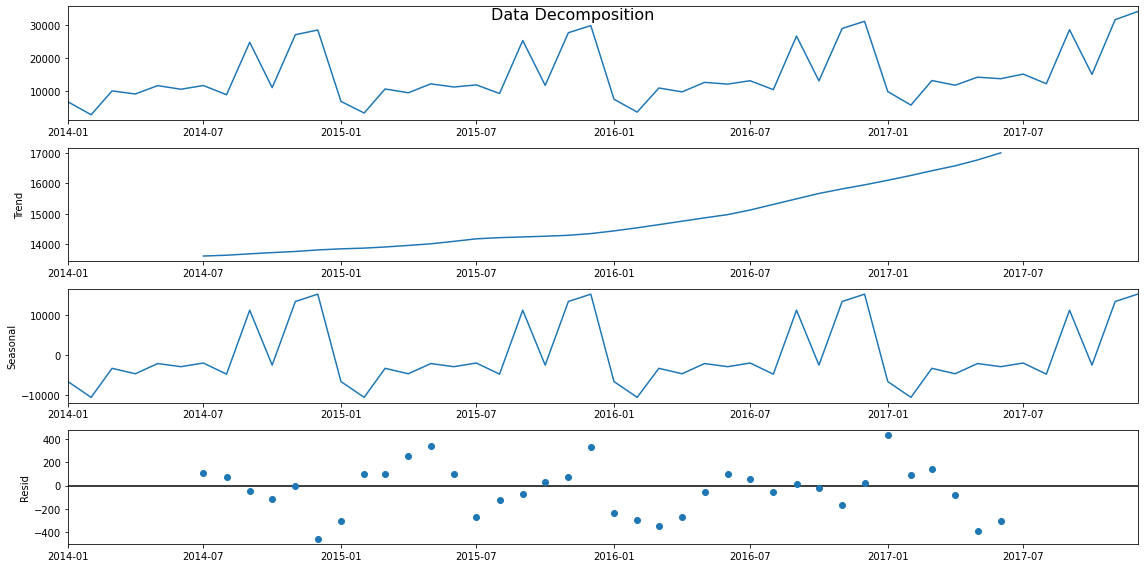

In [335]:
#PLOTS TO CHECK TREND,SEASONALITY,RESIDS
checkcharacterstics(furndata)

*DATA HAS ALL THREE TIME SERIES CHARACTERSTICS TREND, SEASONALITY AND NOISE*

In [336]:
#CHECKING FOR DATA STATIONARITY
checkstationarity(furndata)

'pvalue=9.513079933718842e-05. Data is Stationary. Proceed to model building'

1. *SINCE DATA IS STATIONARY WE CAN MOVE WITH ANY OF THE EITHER ARMA/ARIMA/SARIMA.*
2. *SINCE THERE IS SEASONALITY PRESENT I WILL CHOOSE SARIMA MODEL.*

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


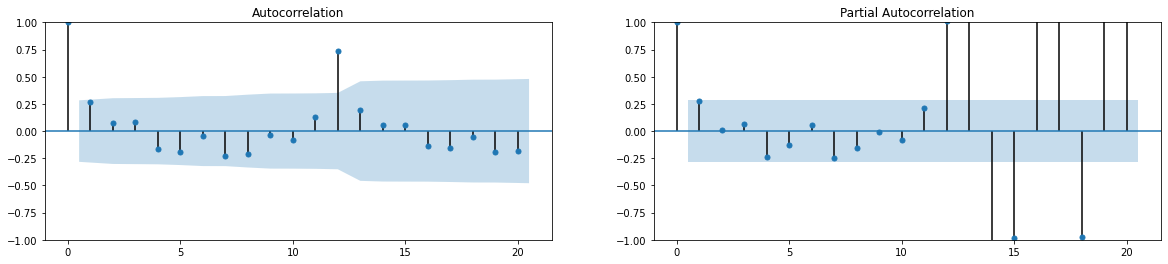

In [337]:
#CHECKING LAG VALUES
plotlag(furndata)

In [338]:
#FINDING BEST P,Q,D,p,q,d values for building the model
m2 = auto_arima(y=furndata,start_p=1,start_q=1,max_p=9,max_q=2,m=12,d=0,D=0,start_P=0,start_Q=0,seasonal=True,error_action='ignore',suppress_warnings=True,trace=True)
print(m2.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1008.144, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1008.133, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=975.883, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=989.458, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1074.445, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1006.161, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=990.474, Time=0.22 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=985.751, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=987.766, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1003.891, Time=0.13 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=989.294, Time=0.27 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1001.164, Time=0.14 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept 

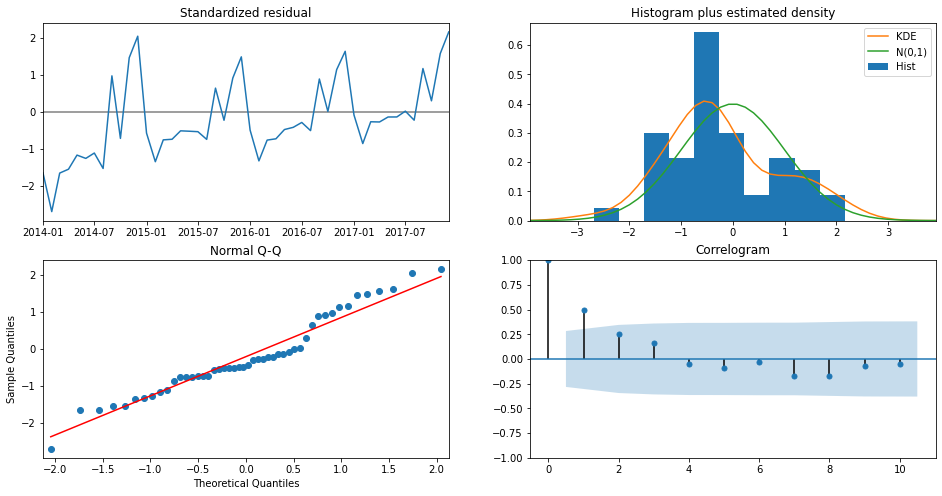

In [339]:
#CHECKING FOR MODEL DIAGNOSTICS BEFORE BULIDING
m2.plot_diagnostics()
plt.show()

1. Standardised Residuals : Thereare no obvious patterns in the residuals.
2. KDE Curve : Shows normal distributions, data is skewed.
3. Normal Q-Q : Most of the data points are on the straight line/normal reference line.

In [340]:
split2 = int(0.8 * len(furndata))
train2 = furndata[:split2]
test2 = furndata[split2:]

In [341]:
#BUILDING THE SARIMA MODEL FOR OFFICE SUPPLIES
furn_model = sm.tsa.statespace.SARIMAX(train2,order=(1,0,1),seasonal_order=(1,0,0,12)).fit()
print(furn_model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   38
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -358.764
Date:                             Tue, 31 Jan 2023   AIC                            725.529
Time:                                     15:03:26   BIC                            732.079
Sample:                                 01-01-2014   HQIC                           727.859
                                      - 02-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.133      7.500      0.000       0.739       1.261
ma.L1         -0.9994      

In [342]:
#LJUNG BOX TEST
ljungoxtest(furn_model)

Reject H0, bad model


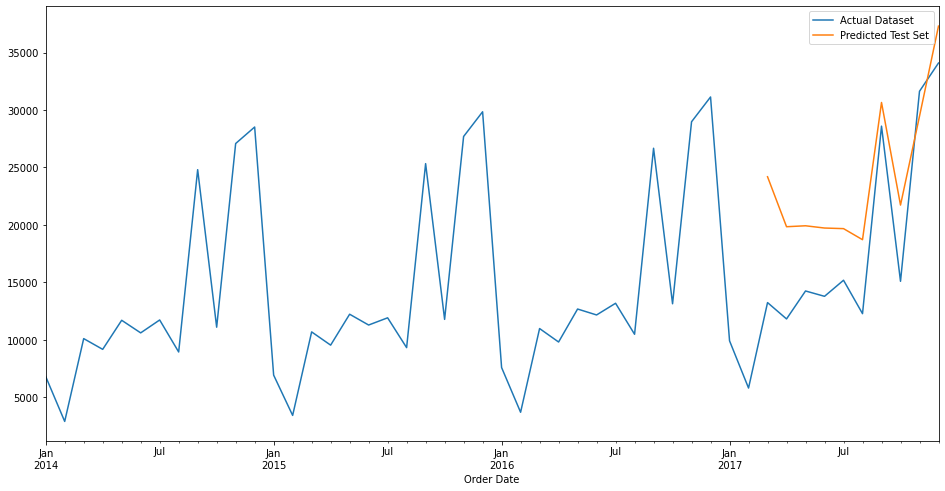

In [343]:
#PERFORMACE METRICS and PREDICTED DATA
pred2 = os_model.predict(start=len(train2),end=len(furndata)-1,dynamic=True)
mse2 = mean_squared_error(test2,pred2)
mape2 = mean_absolute_percentage_error(test2,pred2)
plotpred(furndata,pred2)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


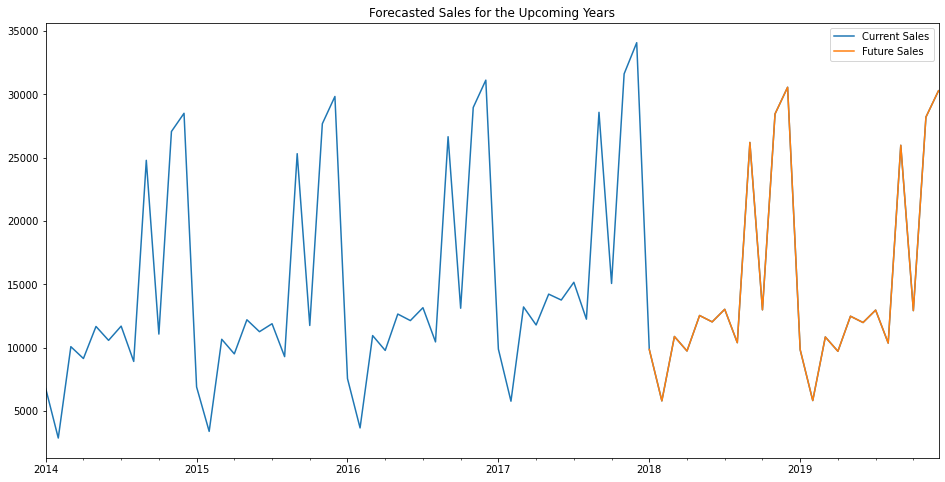

In [344]:
#FORECASTING
forecasting(furn_model,furndata)

INTERPRETATIONS:

1. SARIMA MODEL WAS USED HERE FOR FORECASTING DUE TO THE PRESENCE OF SEASONALITY.
2. DATA WAS STATIONARY IN THIS CATEGORY.
3. PATTERNS ARE VERY SIMILAR TO THE PREVIOUS YEAR SALES RECORD.
4. VERY SLIGHT UPWARD TREND CAN BE SEEN IN THE OVERALL DATA AND THE DATA FORECASTED.
5. YEAR END SALES IN FURNITURE SALES ARE COMPARITIVELY MORE.
6. DIPS IN SALES CAN BE SEEN 1ST QUARTER.

# **TIME SERIES FORECASTING FOR TECHNOLOGY CATEGORY**

In [351]:
#CONVERTING INDEX TO DATE TIME FORMAT 
tech.index = pd.to_datetime(tech.index)

In [352]:
#SORTING THE INDEX
tech.sort_index(ascending=True,inplace=True)

In [353]:
#SAMPLING THE DATA MONTHLY FOR DATA REDUCTION
techdata = tech.resample('MS').sum()
techdata.head()

Order Date
2014-01-01     3143.290
2014-02-01     1608.510
2014-03-01    32511.174
2014-04-01     9195.434
2014-05-01     9599.876
Freq: MS, Name: Sales, dtype: float64

In [354]:
#SMOOTHING
from statsmodels.tsa.api import ExponentialSmoothing
df_smo = ExponentialSmoothing(techdata,trend='add',seasonal='add',seasonal_periods=12).fit()
techdata = df_smo.fittedvalues

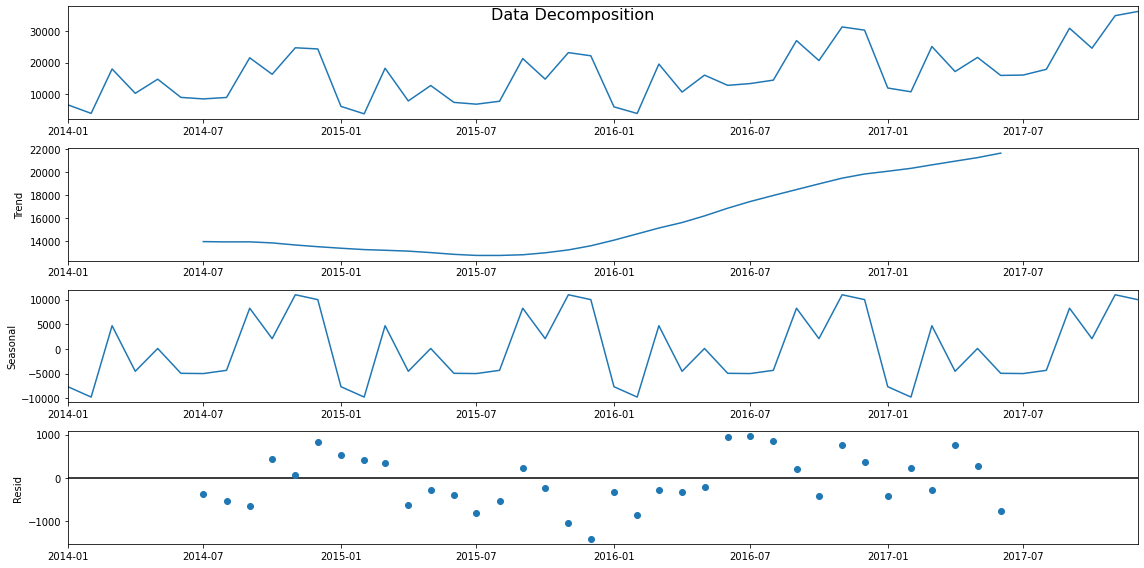

In [355]:
#PLOTS TO CHECK TREND,SEASONALITY,RESIDS
checkcharacterstics(techdata)

*DATA HAS ALL THREE TIME SERIES CHARACTERSTICS TREND, SEASONALITY AND NOISE*

In [356]:
#CHECKING FOR DATA STATIONARITY
checkstationarity(techdata)

'pvalue=0.9852373582089293. Data is not Stationary. Make the data stationary before model building'

In [357]:
techdata_diff = techdata - techdata.shift(1)
techdata_diff.dropna(inplace=True)
checkstationarity(techdata_diff)

'pvalue=1.5818270748199294e-16. Data is Stationary. Proceed to model building'

1. *SINCE DATA IS NOT STATIONARY WE CAN MOVE WITH ANY OF THE EITHER ARMA/ARIMA/SARIMA.*
2. *SINCE THERE IS SEASONALITY PRESENT I WILL CHOOSE SARIMA MODEL.*

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


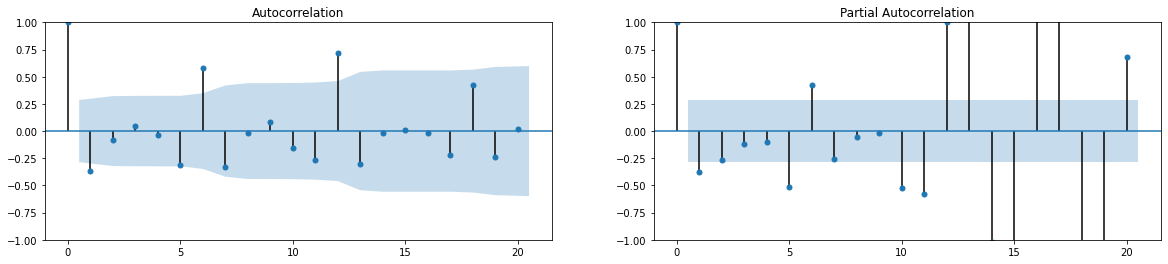

In [293]:
#CHECKING LAG VALUES
plotlag(techdata_diff)

In [294]:
#FINDING BEST P,Q,D,p,q,d values for building the model
m3 = auto_arima(y=techdata,start_p=1,start_q=1,max_p=14,max_q=3,m=12,d=1,D=1,start_P=0,start_Q=0,seasonal=True,error_action='ignore',suppress_warnings=True,trace=True)
print(m3.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=602.198, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=598.230, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=601.606, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=601.604, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=599.802, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=599.680, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=600.176, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=600.193, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=599.435, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.899 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1

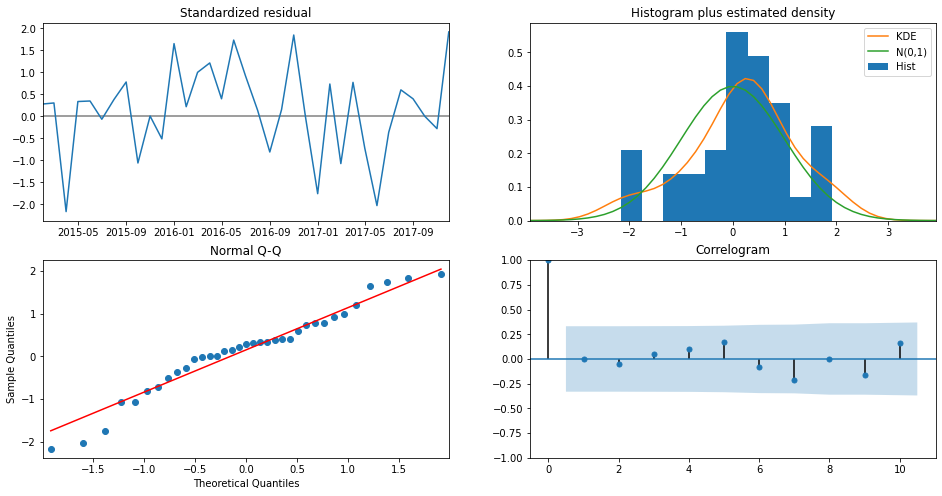

In [295]:
#CHECKING FOR MODEL DIAGNOSTICS BEFORE BULIDING
m3.plot_diagnostics()
plt.show()

1. Standardised Residuals : Thereare obvious patterns in the residuals with no uniform mean and variance.
2. KDE Curve : Dosent show normal distributions, data is skewed.
3. Normal Q-Q : Most of the data points are not on the straight line/normal reference line.

In [358]:
split3 = int(0.8 * len(techdata))
train3 = techdata[:split3]
test3 = techdata[split3:]

In [359]:
#BUILDING THE SARIMA MODEL FOR OFFICE SUPPLIES
tech_model = sm.tsa.statespace.SARIMAX(train3,order=(1,1,1),seasonal_order=(0,1,0,12)).fit()
print(tech_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   38
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -212.577
Date:                             Tue, 31 Jan 2023   AIC                            431.154
Time:                                     15:06:07   BIC                            434.811
Sample:                                 01-01-2014   HQIC                           432.169
                                      - 02-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0709      7.925      0.009      0.993     -15.463      15.604
ma.L1         -0.0871      

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [360]:
#LJUNG BOX TEST
ljungoxtest(tech_model)

Accept H0, good model


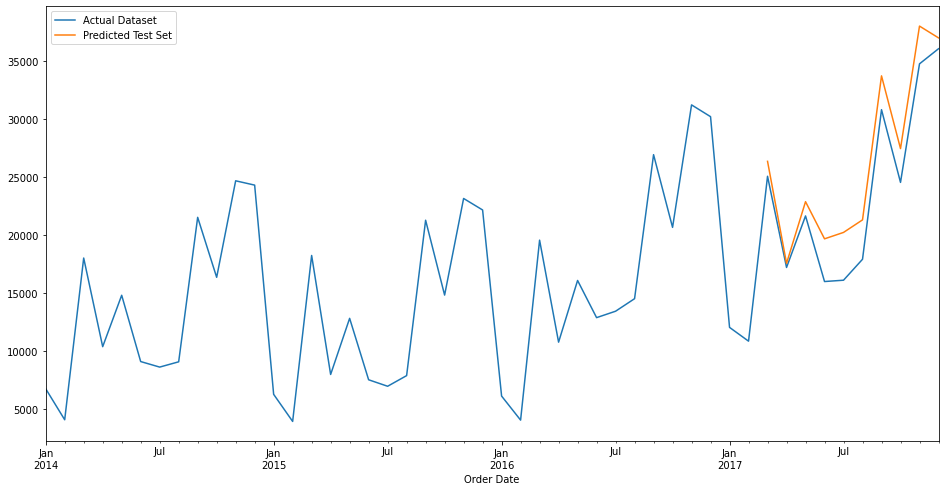

In [361]:
#PERFORMACE METRICS and PREDICTED DATA
pred3 = tech_model.predict(start=len(train3),end=len(techdata)-1,dynamic=True)
mse3 = mean_squared_error(test3,pred3)
mape3 = mean_absolute_percentage_error(test3,pred3)
plotpred(techdata,pred3)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


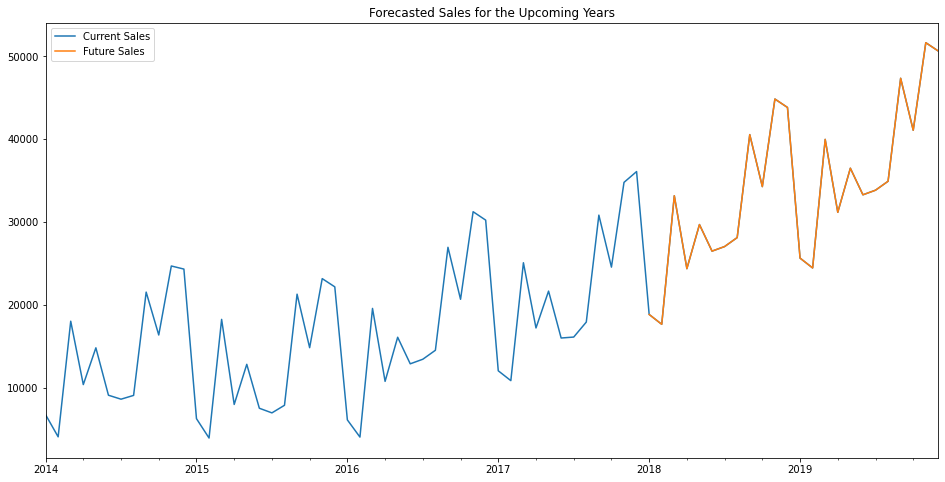

In [362]:
#FORECASTING
forecasting(tech_model,techdata)

INTERPRETATIONS:

1. SARIMA MODEL WAS USED HERE FOR FORECASTING DUE TO THE PRESENCE OF SEASONALITY.
2. DATA WAS NOT STATIONARY IN THIS CATEGORY.
3. PATTERNS ARE QUIET SIMILAR TO THE PREVIOUS YEAR SALES RECORD.
4. STRONG UPWARD TREND CAN BE SEEN IN THE OVERALL DATA AND THE DATA FORECASTED.
5. YEAR END SALES IN TECH SUPPLY CATEGORY ARE COMPARITIVELY MORE.

In [301]:
frame = {'CATEGORY':['OFFICE SUPPLIES','FURNITURE','TECHNOLOGY'],'RMSE':[np.sqrt(mse1),np.sqrt(mse2),np.sqrt(mse3)],'MAPE':[mape1,mape2,mape3]}
table = pd.DataFrame(frame)
table

,CATEGORY,RMSE,MAPE
0,OFFICE SUPPLIES,6586.551225,0.327788
1,FURNITURE,6140.841973,0.383515
2,TECHNOLOGY,2721.212192,0.113917


*MAPE is defined as the percentage of the average of absolute difference between forecasted values and true values, divided by true value.*

*The lower the MAPE, the better the model is.*

# **INNOVATION**

In [367]:
techdata = pd.DataFrame(fdata)
techdata

,0
2014-01-01,6729.032286
2014-02-01,4051.774224
2014-03-01,18015.409966
2014-04-01,10361.914810
2014-05-01,14801.616282
...,...
2019-08-01,34917.944206
2019-09-01,47352.872265
2019-10-01,41075.208297
2019-11-01,51650.875246


In [369]:
techdata[1] = list(techdata.index)

In [372]:
techdata

,Technology_Sales,Date
2014-01-01,6729.032286,2014-01-01
2014-02-01,4051.774224,2014-02-01
2014-03-01,18015.409966,2014-03-01
2014-04-01,10361.914810,2014-04-01
2014-05-01,14801.616282,2014-05-01
...,...,...
2019-08-01,34917.944206,2019-08-01
2019-09-01,47352.872265,2019-09-01
2019-10-01,41075.208297,2019-10-01
2019-11-01,51650.875246,2019-11-01


In [371]:
techdata.rename(columns={0:'Technology_Sales',1:'Date'},inplace=True)

In [373]:
techdata.to_csv('Technology Sales.csv')

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-410-b93ab201a488>", line 12, in update
    x.append(techdata.loc[idx,techdata['Date']])
  File "/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py", line 925, in __getitem__
    return self._getitem_tuple(key)
  File "/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py", line 1100, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "/usr/local/lib/python3.8

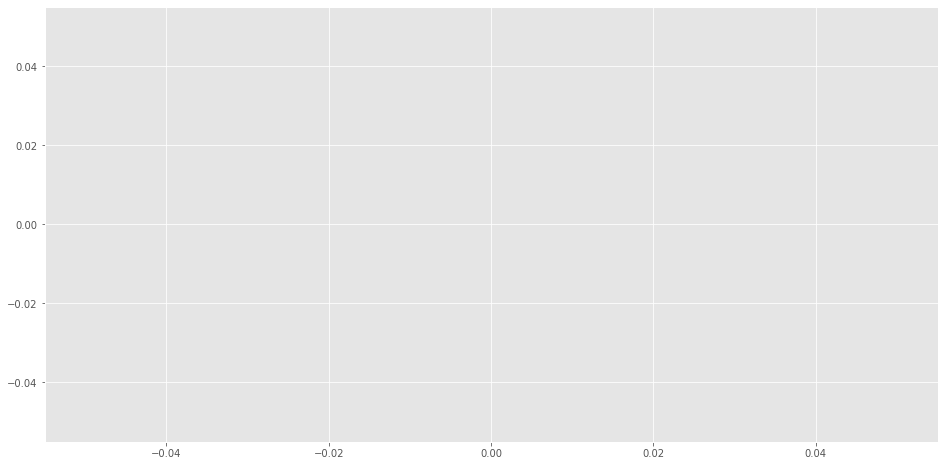

In [410]:
from matplotlib.animation import FuncAnimation
from itertools import count
x=[]
y=[]
fig,ax = plt.subplots()
ax.plot(x,y)
plt.style.use("ggplot")
counter=count(0,1)

def update(i):
  idx=next(counter)
  x.append(techdata.loc[idx,techdata['Date']])
  y.append(techdata.loc[idx,techdata['Technology_Sales']])
  plt.cla()
  ax.plot(x,y)

ani=FuncAnimation(fig=fig,func=update,interval=200,frames = len(x) + 1)
plt.show()

In [385]:
f1 = pd.read_csv("/content/Office Suuply Sales.csv",parse_dates=True,usecols=('Office_Supplies_Sales','Date'),index_col='Date')
f2 = pd.read_csv("/content/Furniture Sales.csv",parse_dates=True,usecols=('Furniture_Sales','Date'),index_col='Date')
f3 = pd.read_csv("/content/Technology Sales.csv",parse_dates=True,usecols=('Technology_Sales','Date'),index_col='Date')

In [396]:
f3

,Technology_Sales
Date,
2014-01-01,6729.032286
2014-02-01,4051.774224
2014-03-01,18015.409966
2014-04-01,10361.914810
2014-05-01,14801.616282
...,...
2019-08-01,34917.944206
2019-09-01,47352.872265
2019-10-01,41075.208297


In [394]:
f1['Furniture_Sales'] = f2.Furniture_Sales

In [397]:
f1['Technology_Sales'] = f3.Technology_Sales

In [398]:
category_forecasts = f1.copy()

In [399]:
category_forecasts

,Office_Supplies_Sales,Furniture_Sales,Technology_Sales
Date,,,
2014-01-01,4851.080000,6790.384086,6729.032286
2014-02-01,1071.724000,2880.555398,4051.774224
2014-03-01,8605.879000,10091.659067,18015.409966
2014-04-01,11155.074000,9156.845289,10361.914810
2014-05-01,7135.624000,11687.553932,14801.616282
...,...,...,...
2019-08-01,29869.816649,10376.759128,34917.944206
2019-09-01,41815.848384,25988.638943,47352.872265
2019-10-01,32883.562624,12937.631855,41075.208297


In [401]:
category_forecasts.to_csv('category_forecasts.csv')

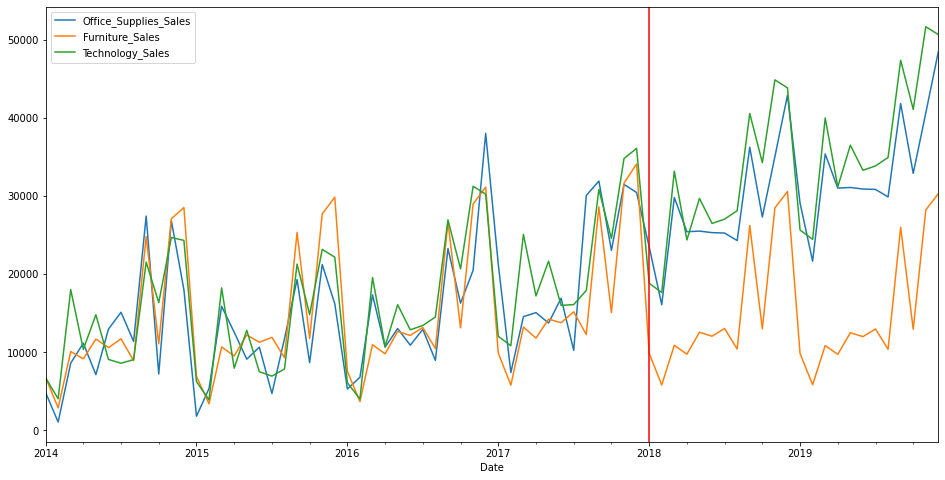

In [404]:
category_forecasts.plot()
plt.axvline(x='2018-01-01',c='red')

In [405]:
import plotly.express as px
fig = px.line(category_forecasts, x=category_forecasts.index, y=category_forecasts.columns)
fig.show()